#### Breast Cancer Classification
<b>About Dataset</b> Found: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 <br></br>
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus. <br></br>
The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius. SE and worst are not needed for classification <br></br>
<b>Objective</b><br></br>
Classifiy if a tumor is malignant or benign based on features given in dataset 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# load data
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


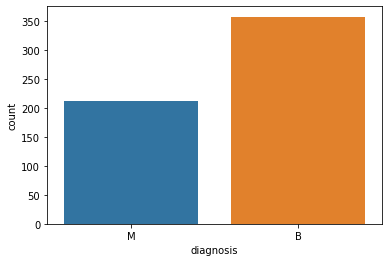

In [2]:
# Visualize target variable
sns.countplot(x='diagnosis', data=df)
plt.show()

In [3]:
# Changing object dtype to category to save memory
df['diagnosis'] = df['diagnosis'].astype('category')

# drop features with _se and _worst
df = df[df.columns.drop(list(df.filter(regex='worst')))]
df = df[df.columns.drop(list(df.filter(regex='se')))]

# drop unecassary features
df = df.drop(['Unnamed: 32', 'id'], axis=1)
df.head()
data = {'M': 1, 'B': 0}
df['diagnosis'] = [data[item] for item in df['diagnosis']]
# Understand data
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 49.0 KB


(569, 11)

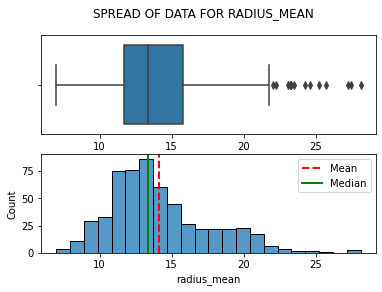

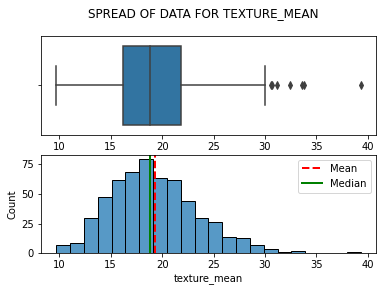

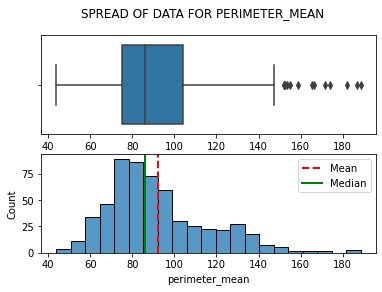

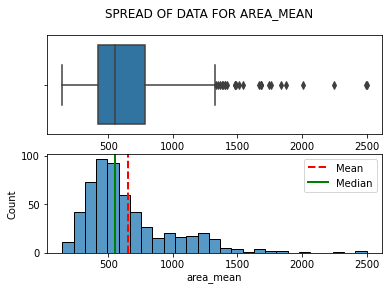

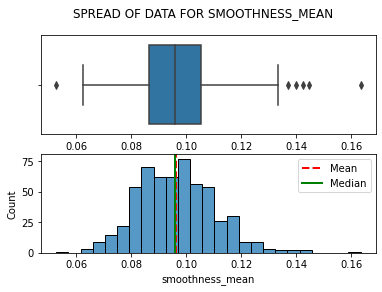

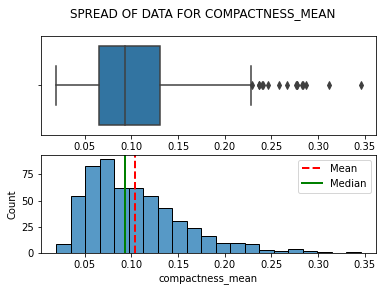

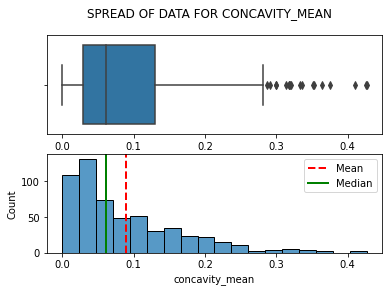

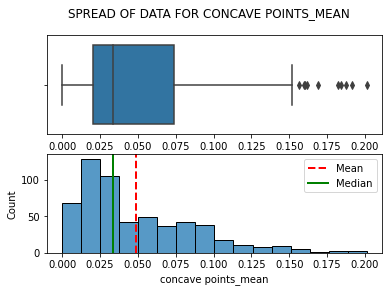

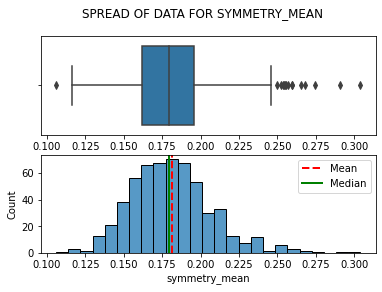

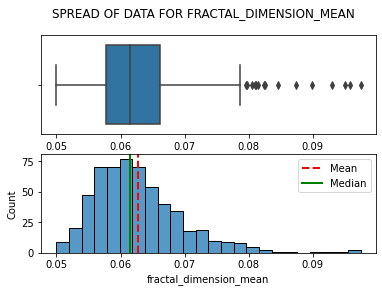

In [4]:
# drop columns that do not have numeric values 
numeric_data = df.drop('diagnosis', axis=1)
def box_hist_plots(data):
    """Make box plots and histograms of data"""
    Name=data.name.upper()
    mean=data.mean()
    median=data.median()
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle("SPREAD OF DATA FOR " + Name)
    sns.boxplot(x=data, data=data, ax=ax1)
    sns.histplot(data, ax=ax2)
    # create mean and median line on histogram plot
    ax2.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax2.axvline(median, color='g', linestyle='-',linewidth=2)
    plt.legend({'Mean': mean, 'Median': median})

numeric_columns = numeric_data.columns
for i in range(len(numeric_columns)):
    box_hist_plots(df[numeric_columns[i]])

OBSERVATIONS: <br></br>
All plots have some to many outliers at the higher end with smooth_mean and symmetry_mean haveing 1 outlier on the lower end.<br></br>
Texture_mean, smoothness_mean, and symmetry_mean are normally distributed and the rest are right-skewed.


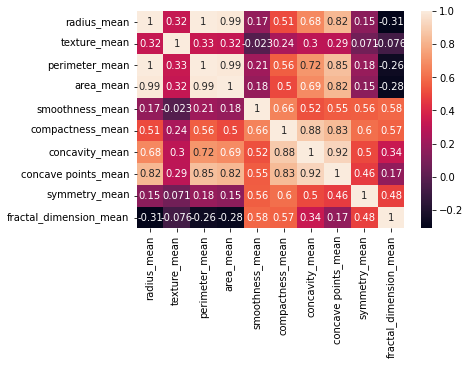

In [5]:
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

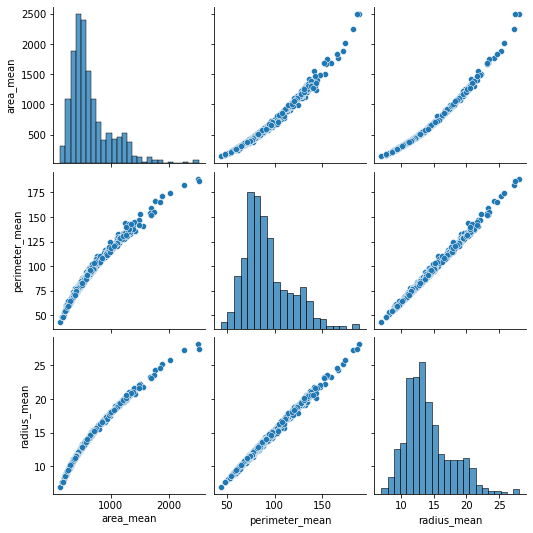

In [6]:
# df_mean = df.loc[:, df.columns.str.endswith('mean')]
cols_measure = df[['area_mean', 'perimeter_mean', 'radius_mean']]
sns.pairplot(cols_measure)
plt.show()

#### Logistic Regression/Base Model

In [7]:
# Split data into features and target variables
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

In [8]:
# split data into 70% training and 30% testing
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
# MinMaxScaler to make the algorithm converge under max_iter=100
pipe = make_pipeline(MinMaxScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print(f'Model accuracy of: % {round(score * 100, 2)}')

Model accuracy of: % 94.15


In [10]:
predictions = pipe.predict(X_test)
predictions

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [11]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)
# Jaccard score is size of the intersection divided by the size of the union of two label sets: tp / (tp + fp + fn)
print(f'Model jaccard score of: % {round(jaccard_score(y_test, predictions) * 100, 2)}') 

[[106   2]
 [  8  55]]
Model jaccard score of: % 84.62


#### Conclusion
Not a great model since it incorrectly identified 10 cases in the test set. Seems that some features are generating too much noise. Can try to reduce noise and try LR again but instead try to reduce amount of features used. Will select features based on chi-squared function using Select K Best from sklearn below.

In [12]:
# drop features with _se and _worst
df = df[df.columns.drop(list(df.filter(regex='worst')))]
df = df[df.columns.drop(list(df.filter(regex='se')))]

# drop unecassary features
# df = df.drop(['Unnamed: 32', 'id'], axis=1)

X = df.drop("diagnosis", axis=1)
y = df['diagnosis']

# Using SelectKBest to determine feature importance
bf = SelectKBest(score_func=chi2, k=5)
fit = bf.fit(X, y)

In [13]:
# Create pandas DF to visualize scores given by SelectKBest
dfscore = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [14]:
# display df
feature_scores = pd.concat([dfcolumns, dfscore], axis=1)
feature_scores.columns = ['Columns', 'Score']
feature_scores

,Columns,Score
0,radius_mean,266.104917
1,texture_mean,93.897508
2,perimeter_mean,2011.102864
3,area_mean,53991.655924
4,smoothness_mean,0.149899
5,compactness_mean,5.403075
6,concavity_mean,19.712354
7,concave points_mean,10.544035
8,symmetry_mean,0.257380
9,fractal_dimension_mean,0.000074


In [15]:
# Get the top 5 features
print(feature_scores.nlargest(5, 'Score'))

          Columns         Score
3       area_mean  53991.655924
2  perimeter_mean   2011.102864
0     radius_mean    266.104917
1    texture_mean     93.897508
6  concavity_mean     19.712354


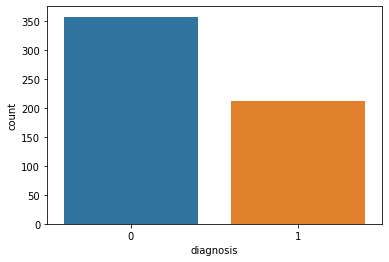

In [33]:
# using 5 features selected from SelectKBest
X = df[['area_mean', 'perimeter_mean', 'radius_mean', 'texture_mean', 'concavity_mean']]
y = df["diagnosis"]
sns.countplot(x=y)
plt.show()

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.30, random_state=42)

In [17]:
# new pipeline with new data
pipe2 = make_pipeline(MinMaxScaler(), LogisticRegression())
pipe2.fit(X_train, y_train)

score2 = pipe2.score(X_test, y_test)
print(f'Model accuracy of: % {round(score2 * 100, 2)}')

Model accuracy of: % 93.57


In [18]:
predictions = pipe2.predict(X_test)
predictions

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [19]:
conf_matrix2 = confusion_matrix(y_test, predictions)
print(conf_matrix2)
# Jaccard score is size of the intersection divided by the size of the union of two label sets: tp / (tp + fp + fn)
print(f'Model jaccard score of: % {round(jaccard_score(y_test, predictions) * 100, 2)}') 

[[106   2]
 [  9  54]]
Model jaccard score of: % 83.08


#### Conclusion
Looking at the features selected by SelectKBest and the analysis done at the beggining 3 out of the 5 features are highly correlated. This means that features can be reduced again without much information lossed. This finding can serve as a next step for this model but since 11 patients total were misdiagnosed which is one more than using all features, another model will be used to see if misdiagnosis can be reduced. Below the model that will be used is Recursive feature elimination with cross-validation (RFECV) to select features using Random Forest Classifier as estimator function.
Random forest classifier is a non-linear classifier, data is slightly unbalanced are the reasons why RFC was used as the estimator function. 

In [20]:
df = pd.read_csv('data.csv')
data = {'M': 1, 'B': 0}
df['diagnosis'] = [data[item] for item in df['diagnosis']]


# drop features with _se and _worst
df = df[df.columns.drop(list(df.filter(regex='worst')))]
df = df[df.columns.drop(list(df.filter(regex='se')))]

# drop unecassary features
df = df.drop(['Unnamed: 32', 'id'], axis=1)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']


X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.30, random_state=42)

# defualt for RFECV is 5-fold cross-validation
m = RFECV(RandomForestClassifier(random_state=24), scoring='jaccard', min_features_to_select=2)
m.fit(X_train, y_train)

RFECV(estimator=RandomForestClassifier(random_state=24),
      min_features_to_select=2, scoring='jaccard')

In [21]:
print(f'Model accuracy of: % {round(m.score(X_test, y_test) * 100, 2)}')
print(f'All possible columns that can be selected: \n {X.columns}')
print(f'Selected columns: \n {m.support_}')

Model accuracy of: % 96.49
All possible columns that can be selected: 
 Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'],
      dtype='object')
Selected columns: 
 [ True  True  True  True  True  True  True  True False False]


In [22]:
# Create confusion table
y_predict = m.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predict)
TN = conf_matrix[0, 0]
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
FP = conf_matrix[0, 1]
print(conf_matrix)
print(f'Model jaccard score of: % {round(jaccard_score(y_test, y_predict) * 100, 2)}') 

[[104   4]
 [  2  61]]
Model jaccard score of: % 91.04


In [23]:
# True negative rate
sp = TN / (TN + FP) 
print(f'True negative rate: % {round(sp * 100, 2)}')

True negative rate: % 96.3


In [24]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
print(f'Recall score / True positive rate: % {round(recall_score(y_test,predictions) * 100, 2)}')

Recall score / True positive rate: % 85.71


In [32]:
sn = TP / (TP + FN)
print(f'Sensitivity or number of correct positive predictions: % {round(sn * 100, 2)}')

Snnsitivity or number of correct positive predictions: % 96.83


What scoring metric is best to use when training the model: accuracy, recall, jaccard? Testing for each done below

TN(0,0) FP(0,1) <br></br>
FN(1,0) TP(1,1) <br></br>
jaccard: TN: 104 FP:4 FN:2 TP:61 Better: TN, TP, FP, FN <br></br>
accuracy: TN: 103 FP:5 FN:3 TP:60 Better: None <br></br>
jaccard is better metric to use<br></br>
jaccard and recall score the same, either is fine to use 

#### Conclusion 
RFECV model accuracy scored the best out of the 3 model with only misdiagnosing 6 patients and correctly diagnosing 165! Doing this with only 8 features total. A next step would be to get find of noise/outliers in the remaining features to see how scores will be affected, and getting rid of features with high correlations. 